# Compare iron transects from Geotraces to BGC output in Southern Ocean

In [41]:
import xarray as xr
import pandas as pd
import numpy as np
import gsw
import matplotlib.pyplot as plt
from glob import glob
import cmocean as cmo
from palettable.scientific.sequential import Hawaii_20_r
import cosima_cookbook as cc

In [2]:
from dask.distributed import Client
client = Client()
client

<Client: 'tcp://127.0.0.1:41671' processes=6 threads=18, memory=200.00 GiB>

## First plot decadally averaged model transects (zonally averaged) across Southern Ocean (to assess drift). 

Read in BGC model data manually myself (database was too slow). 

In [3]:
%%time
datadir = '/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf_cycle4/'
files = sorted(glob(datadir + '/output*/ocean/oceanbgc-3d-fe-1-monthly-mean-3-sigfig-ym_*.nc'))

def preproc(ds):
    return ds.sel(yt_ocean=slice(None,-30))#.mean(dim='xt_ocean')#.sel(time=slice(start_time, end_time))

CPU times: user 378 ms, sys: 250 ms, total: 628 ms
Wall time: 1.11 s


Define functions 

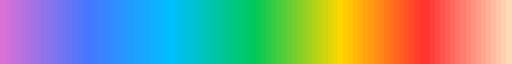

In [3]:
decades = [ ('1950-01-02' , '1959-12-30'), 
            ('1960-01-02' , '1969-12-30'),
            ('1970-01-02' , '1979-12-30'),
            ('1980-01-02' , '1989-12-30'),
            ('1990-01-02' , '1999-12-30'),
            ('2000-01-02' , '2009-12-30'),
            ('2010-01-02' , '2019-12-30'),]

decade_labels = [ ('1958' , '1959'), 
                 ('1960' , '1969'),
                 ('1970' , '1979'),
                 ('1980' , '1989'),
                 ('1990' , '1999'),
                 ('2000' , '2009'),
                 ('2010' , '2019'),]

def fig_so_zonal_mean():
    plt.rcParams.update({'font.size': 14})
    fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(21,8), sharey=True, sharex=True)
    plt.subplots_adjust(wspace=0.06, hspace=0.06)
    axes[0][0].set_ylabel('Depth (m)')
    axes[1][0].set_ylabel('Depth (m)')

    axes[1][0].set_xlabel('Latitude (\u00b0S)')
    axes[1][1].set_xlabel('Latitude (\u00b0S)')
    axes[1][2].set_xlabel('Latitude (\u00b0S)')
    #axes[1][3].set_xlabel('Latitude (\u00b0C)')
    axes[1][3].axis('off')
    return fig, axes

def plot_iron(axes, fe, cmap):
    vmin, vmax = 0.2, 0.8
    # pcolormesh background
    cb = axes.pcolormesh(fe.yt_ocean, fe.st_ocean, fe, cmap=cmap, vmin=vmin, vmax=vmax)
    # contour values
    x = fe.yt_ocean.values
    y = fe.st_ocean.values
    X,Y = np.meshgrid(x,y)
    levels1 = np.arange(0.1, 1.1, 0.1)
    cs = axes.contour(X, Y, fe, levels1, colors='grey', linewidths=0.5)
    levels2 = np.arange(0, 1.2, 0.2)
    cs = axes.contour(X, Y, fe, levels2, colors='k', linewidths=0.8)
    axes.clabel(cs, cs.levels, inline=True, fontsize=10)
    # invert y-axis so depth increases toward bottom
    axes.invert_yaxis()
    # label decade
    axes.text(0.05,0.1,f'{decade_labels[i][0]}-{decade_labels[i][1]}', fontsize = 13, c='k',
              bbox=dict(facecolor='w', edgecolor='dimgrey', boxstyle='round,pad=0.2'),
              transform = axes.transAxes)
    return cb

def plot_colorbar(fig,axes_loc,cb_item,label):
    fontsize=14
    cbaxes = fig.add_axes(axes_loc)
    cbar = plt.colorbar(cb_item, cax = cbaxes, orientation = 'vertical',extend = 'both', shrink=0.5)
    cbar.set_label(label,fontsize=fontsize,labelpad=2)
    cbar.ax.tick_params(labelsize=12)
    return cbar

def custom_colormaps(name):

    import matplotlib.colors as mcolors
    import numpy as np

    if name == 'bathymetry':
        cmap_colors = ['#DA70D6', '#4876FF', '#00BFFF', '#00C957', 
                       '#FFD700','#FF3030','#FFDAB9',] #FFDAB9 #FFD39B
        cmap = mcolors.LinearSegmentedColormap.from_list(name=name, colors=cmap_colors, N=250, gamma=1)
    return cmap

cmapfe = custom_colormaps('bathymetry')._resample(100)
cmapfe

2022-12-09 15:16:08,754 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 26.79 GiB -- Worker memory limit: 33.33 GiB
2022-12-09 15:16:10,513 - distributed.worker.memory - WARNING - Worker is at 63% memory usage. Resuming worker. Process memory: 21.18 GiB -- Worker memory limit: 33.33 GiB
2022-12-09 15:32:07,542 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 26.79 GiB -- Worker memory limit: 33.33 GiB
2022-12-09 15:32:09,330 - distributed.worker.memory - WARNING - Worker is at 71% memory usage. Resuming worker. Process memory: 23.99 GiB -- Worker memory limit: 33.33 GiB


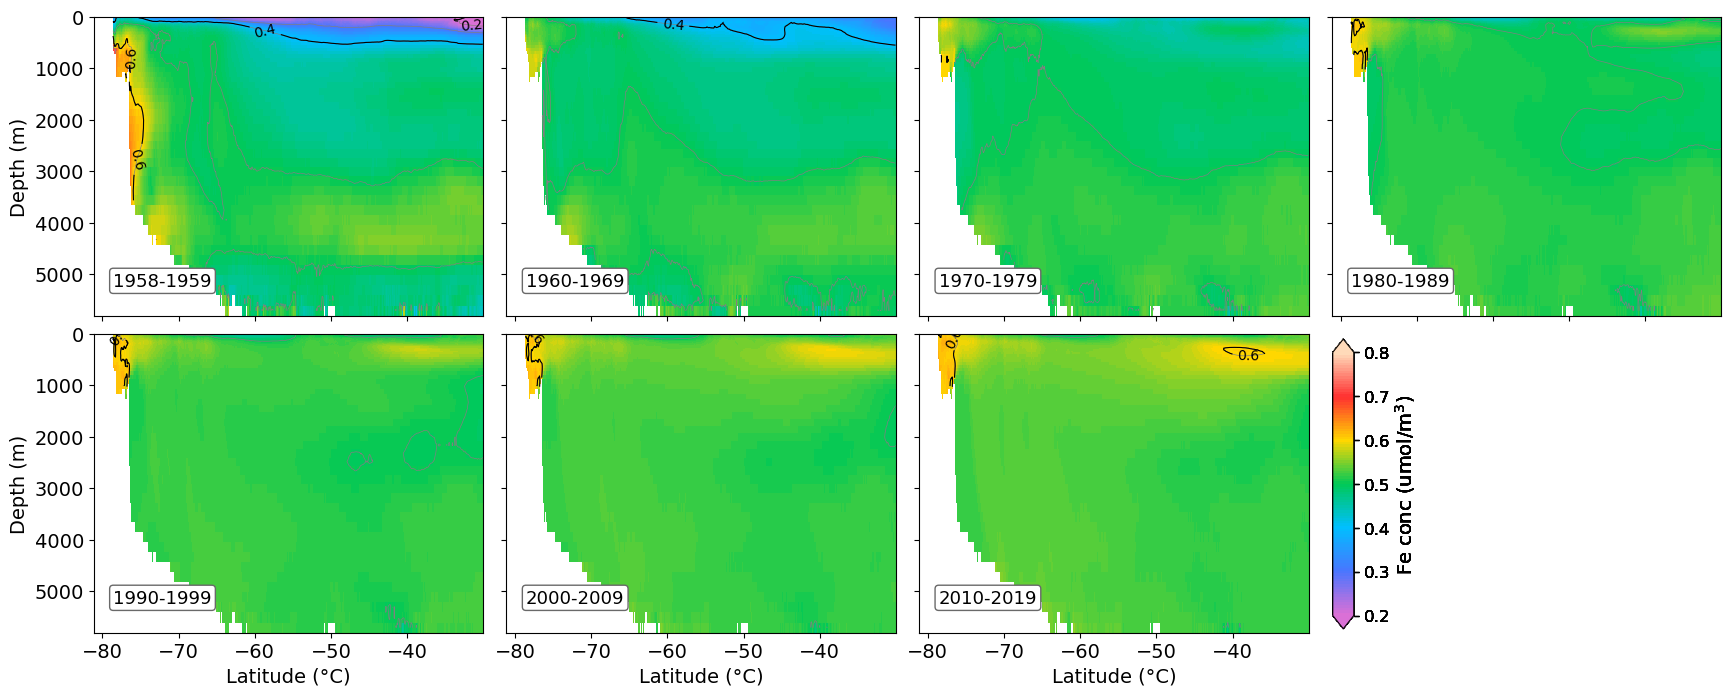

CPU times: user 10min 8s, sys: 1min 20s, total: 11min 29s
Wall time: 50min 2s


In [431]:
%%time
fig, axes = fig_so_zonal_mean()

for i in range(7):
    # define decade
    start_time = decades[i][0]
    end_time = decades[i][1]
    # open model 
    fe_mod = xr.open_mfdataset(files, preprocess=preproc).fe
    fe_mod = fe_mod.sel(time=slice(start_time, end_time)).mean(dim='time').mean(dim='xt_ocean').compute()
    cb = plot_iron(axes.flatten()[i], fe_mod, cmapfe)
    
    plot_colorbar(fig,[0.715, 0.115, 0.01, 0.362],cb,'Fe conc (umol/m$^{3}$)')
plt.show()
fig.savefig('../figs/Fe_SO_model_transects_bydecadeA.jpg', bbox_inches='tight', dpi=200)

In [744]:
def fig_surface_mean():
    plt.rcParams.update({'font.size': 14})
    fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(21,8), sharey=True, sharex=True)
    plt.subplots_adjust(wspace=0.06, hspace=0.06)
    axes[0][0].set_ylabel('Latitude (\u00b0S)')
    axes[1][0].set_ylabel('Latitude (\u00b0S)')

    axes[1][0].set_xlabel('Longitude (\u00b0E)')
    axes[1][1].set_xlabel('Longitude (\u00b0E)')
    axes[1][2].set_xlabel('Longitude (\u00b0E)')
    #axes[1][3].set_xlabel('Latitude (\u00b0C)')
    axes[1][3].axis('off')
    return fig, axes

def preproc(ds):
    return ds.sel(st_ocean=slice(0,50))#.mean(dim='xt_ocean')#.sel(time=slice(start_time, end_time))

def plot_iron_map(axes, fe, cmap):
    vmin, vmax = 0.0, 0.8
    # pcolormesh background
    cb = axes.pcolormesh(fe.xt_ocean, fe.yt_ocean, fe, cmap=cmap, vmin=vmin, vmax=vmax)
    # contour values
    x = fe.xt_ocean.values
    y = fe.yt_ocean.values
    X,Y = np.meshgrid(x,y)
    levels1 = np.arange(0.1, 1.1, 0.1)
    cs = axes.contour(X, Y, fe, levels1, colors='grey', linewidths=0.5)
    levels2 = np.arange(0, 1.2, 0.2)
    cs = axes.contour(X, Y, fe, levels2, colors='k', linewidths=0.8)
    axes.clabel(cs, cs.levels, inline=True, fontsize=8)
    # label decade
    axes.text(0.02,0.85,f'{decade_labels[i][0]}-{decade_labels[i][1]}', fontsize = 12, c='k',
              bbox=dict(facecolor='w', edgecolor='dimgrey', boxstyle='round,pad=0.2'),
              transform = axes.transAxes)
    return cb

In [733]:
ht = xr.open_dataset(datadir + '/output780/ocean/ocean-2d-ht.nc').ht
httmp = ht*0
#httmp = httmp.fillna(1)

0
1
2
3
4
5
6


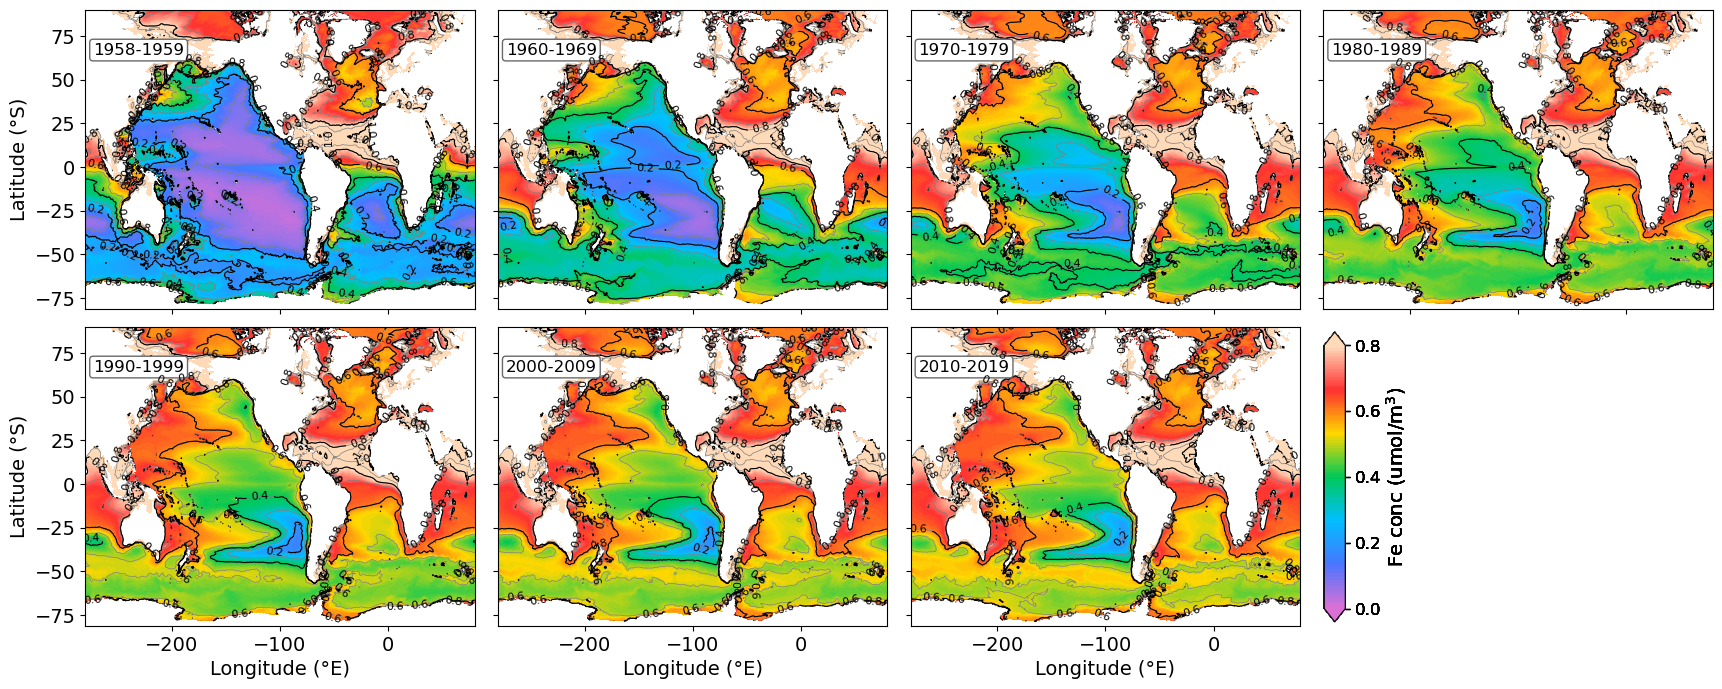

In [746]:
fig, axes = fig_surface_mean()

for i in range(7):
    print(i)
    # define decade
    start_time = decades[i][0]
    end_time = decades[i][1]
    # open model 
    fe_mod = xr.open_mfdataset(files, preprocess=preproc).fe
    fe_mod = fe_mod.sel(time=slice(start_time, end_time)).mean(dim='time').mean(dim='st_ocean').compute()
    
    cb = plot_iron_map(axes.flatten()[i], fe_mod, cmapfe)
    #axes.flatten()[i].pcolormesh(httmp.xt_ocean, httmp.yt_ocean, httmp, cmap='Greys', )
    plot_colorbar(fig,[0.715, 0.115, 0.01, 0.362],cb,'Fe conc (umol/m$^{3}$)')

plt.show()
fig.savefig('../figs/Fe_SO_model_surface_maps_bydecade.jpg', bbox_inches='tight', dpi=200)

## Now compare against GEOTRACES transects. 

Read in data. This is a bit of a mess (variable not defined, poor structure etc.), plus we only need iron. So here I'll extract relevant data, sort into indivual transects, reindex and save to individual netcdf files. 

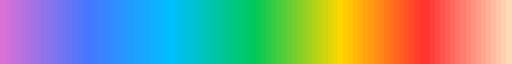

In [754]:
def extract_geotraces_cruise(cruiseID):
    '''
    Function to extract iron dataset from the GEOTRACES IDP 2021 for a specific cruise. 
    cruise: String containing target cruise. Must match those on the GEOTRACES website: 
            https://egeotraces.org/?group=Dissolved%20Trace%20Elements,variable=Fe%20dissolved
    
    Author: Hannah Dawson, adapted from Annette Stellema
    Position: PhD Candidate, UNSW
    Date: 9 Dec 2022
    
    Note: Requires access to project ua8 on Gadi. 
    '''
    # Open GEOTRACES IDP
    datafile = '/g/data/ua8/GEOTRACES/idp2021/GEOTRACES_IDP2021_v1/seawater/netcdf/GEOTRACES_IDP2021_Seawater_Discrete_Sample_Data_v1.nc'
    ds = xr.open_dataset(datafile)
    
    # rename variables and drop unnecessary ones (there are 100s!)
    ds = ds.rename({'var2': 'depth','metavar2':'station'})
    # drop variables that are not time, depth, iron related
    var = ['var{}'.format(v) for v in np.concatenate([np.arange(3), [2, 88, 89]])] # 88 - dissolved Fe, 89 = dissolved Fe2+
    drop_vars = [v for v in ds.data_vars if v not in var]
    drop_vars = [v for v in drop_vars if v not in ['metavar1','station','date_time', 'depth', 'latitude', 'longitude']]
    ds = ds.drop(drop_vars)
    ds = ds.drop(['var1'])
    
    # Extract individual data arrays since you can't subset datasets using index locations
    cruise = np.full(len(ds.metavar1), 'sssssss')
    for i in range(len(cruise)):
        cruise[i] = str(ds.metavar1[i].data)[2:-1]  
    #station = np.full(len(ds.station), 'sssssss')
    #for i in range(len(station)):
    #    station[i] = str(ds.station[i].data)[2:-1]  
    lon = ds.longitude
    lat = ds.latitude
    
    # subset for specific cruise
    cruiseidx = np.where(cruise==cruiseID)[0]
    cruise = cruise[cruiseidx]
    lon = lon[cruiseidx]
    lat = lat[cruiseidx]
    
    if (cruise == 'GP19').all():
        # one bad point in this cruise - it's not on the transect
        lon = lon[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,15,]]
        lat = lat[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,15,]]

    # now use these lat and lon values to subset the original GEOTRACES dataset
    ds = ds = ds.where(ds.longitude.isin(lon),drop=True)
    ds = ds.where(ds.latitude.isin(lat),drop=True)
    
    return ds

# ----------------------------------------------------------------------
def manual_interp(ds, dirn, ztarget, lattarget, lontarget, ironvar):
    '''
    Having trouble interpolating the cruise data in 2D, so will do it manually. 
    '''
    
    from scipy.interpolate import interp1d
    
    if dirn == 'latitude':
        #ztarget = np.concatenate((np.arange(10,300,10),np.arange(300,5650,100)))
        fe_zinterp = np.full((len(ds.latitude), len(ztarget)), np.nan)
        fe_zinterp = xr.DataArray(fe_zinterp,dims=['lat', 'z'], coords=dict(lat = ds.latitude.values, z=ztarget))
    
        for i in range(len(ds.latitude)):
            z = ds.depth[i,:]
            if ironvar.lower() == 'fe': #total Fe
                y = ds.var88[i,:]
            else:
                y = ds.var89[i,:] # Fe2+
            z = z.where(np.isfinite(y), drop=True)
            y = y.where(np.isfinite(y), drop=True)
            if len(y) >= 2:
                f = interp1d(z,y, kind='linear',bounds_error=False, fill_value=np.nan)
                fe_zinterp[i,:] = f(ztarget)
    
        #lattarget = np.arange(ds.latitude.min(), ds.latitude.max(),dx)
        fe_fullinterp = np.full((len(lattarget), len(ztarget)), np.nan)
        for i in range(len(ztarget)):
            x = ds.latitude.values
            y = fe_zinterp[:,i]
            x = x[np.where(np.isfinite(y))]
            y = y.where(np.isfinite(y), drop=True)
            if len(x) >=2:
                f = interp1d(x,y, kind='linear',bounds_error=False, fill_value=np.nan)
                fe_fullinterp[:,i] = f(lattarget)
            else:
                fe_fullinterp[:,i] = np.nan
        
        # convert to data array
        fe_fullinterp = xr.DataArray(fe_fullinterp,dims=['lat', 'z'], coords=dict(lat = lattarget, z=ztarget))
    else:
        #ztarget = np.concatenate((np.arange(10,300,10),np.arange(300,5650,100)))
        fe_zinterp = np.full((len(ds.longitude), len(ztarget)), np.nan)
        fe_zinterp = xr.DataArray(fe_zinterp,dims=['lon', 'z'], coords=dict(lon = ds.longitude.values, z=ztarget))
    
        for i in range(len(ds.longitude)):
            z = ds.depth[i,:]
            if ironvar.lower() == 'fe': #total Fe
                y = ds.var88[i,:]
            else:
                y = ds.var89[i,:] # Fe2+
            z = z.where(np.isfinite(y), drop=True)
            y = y.where(np.isfinite(y), drop=True)
            if len(y) >= 2:
                f = interp1d(z,y, kind='linear',bounds_error=False, fill_value=np.nan)
                fe_zinterp[i,:] = f(ztarget)
        
        #lontarget = np.arange(ds.longitude.min(), ds.longitude.max(),dx)
        fe_fullinterp = np.full((len(lontarget), len(ztarget)), np.nan)
        for i in range(len(ztarget)):
            x = ds.longitude.values
            y = fe_zinterp[:,i]
            x = x[np.where(np.isfinite(y))]
            y = y.where(np.isfinite(y), drop=True)
            if len(x) >=2:
                f = interp1d(x,y, kind='linear',bounds_error=False, fill_value=np.nan)
                fe_fullinterp[:,i] = f(lontarget)
            else:
                fe_fullinterp[:,i] = np.nan
        
        # convert to data array
        fe_fullinterp = xr.DataArray(fe_fullinterp,dims=['lon', 'z'], coords=dict(lon = lontarget, z=ztarget))
        
    return fe_fullinterp
    
# ----------------------------------------------------------------------  
def transect_fig_lat(geotracesfe, modelfe, ironvar):
    fig, axes = plt.subplots(ncols=1, nrows=3, figsize=(11,11), sharey=True, sharex=True)
    plt.subplots_adjust(hspace=0.05)
    vmin, vmax = 0, 2
    levels1, levels2 = np.arange(0.0, 2.1, 0.1), np.arange(0, 2.2, 0.2)
    
    # GEOTRACES interpolated iron ----------------------------------
    cb = axes[0].pcolormesh(geotracesfe.lat, geotracesfe.z, geotracesfe.T, cmap = cmapfe, vmin=vmin, vmax=vmax)
    # contour values
    x = geotracesfe.lat.values
    y = geotracesfe.z.values
    X ,Y = np.meshgrid(x,y)
    cs = axes[0].contour(X, Y, fetmp.T, levels1, colors='grey', linewidths=0.5)
    cs = axes[0].contour(X, Y, fetmp.T, levels2, colors='k', linewidths=0.8)
    axes[0].clabel(cs, cs.levels, inline=True, fontsize=10)
    # scatter actual bottl data locations
    for i in range(len(feds.latitude)):
        z = feds.depth[i,:]
        if ironvar.lower() == 'fe': #total Fe
            fe = feds.var88[i,:]
        else:
            fe = feds.var89[i,:] # Fe2+
        #fe = feds.var88[i,:]
        fe = fe.where(z>=0, drop=True)
        z = z.where(z>=0, drop=True)
        axes[0].scatter(np.full(len(z), feds.latitude[i]), z,  c=fe,
                   cmap = cmapfe, vmin=vmin, vmax=vmax, 
                   edgecolors='w',) 
    axes[0].set_xlim([-65,0.5])
    axes[0].set_ylim([0,5650])
    axes[0].invert_yaxis()
    # add colorbar
    plot_colorbar(fig,[0.92, 0.376, 0.015, 0.5],cb,'Iron (nmol/kg)')
    
    # model transect -------------------------------------------------
    axes[1].pcolormesh(modelfe.yt_ocean, modelfe.st_ocean, modelfe, 
                     cmap = cmapfe, vmin=vmin, vmax=vmax,)
    x = modelfe.yt_ocean.values
    y = modelfe.st_ocean.values
    X ,Y = np.meshgrid(x,y)
    cs = axes[1].contour(X, Y, modelfe, levels1, colors='grey', linewidths=0.5)
    cs = axes[1].contour(X, Y, modelfe, levels2, colors='k', linewidths=0.8)
    axes[1].clabel(cs, cs.levels, inline=True, fontsize=10)
    axes[1].set_ylabel('Depth (m)')
    
    # Difference between model and GEOTRACES obs ----------------------
    cb = axes[2].pcolormesh(modelfe.yt_ocean, modelfe.st_ocean, modelfe - geotracesfe.T.values, 
                     cmap = cmo.cm.balance, vmin=-1, vmax=1,)
    cs = axes[2].contour(X, Y, modelfe-geotracesfe.T.values, levels1, colors='grey', linewidths=0.5)
    cs = axes[2].contour(X, Y, modelfe-geotracesfe.T.values, levels2, colors='k', linewidths=0.8)
    axes[2].clabel(cs, cs.levels, inline=True, fontsize=10)
    axes[2].set_xlabel('Latitude ($\u00B0$S)')
    # add colorbar
    plot_colorbar(fig,[0.92, 0.11, 0.015, 0.25],cb,'$\Delta$ Fe (nmol/kg)')
    
    # Plot title ------------------------------------------------------
    axes[0].set_title(f'GEOTRACES transect {str(feds.metavar1[0].values)[2:-1]}')
    # Plot labels
    labels = [f'GEOTRACES:  {str(feds.date_time.min().values)[0:10]} - {str(feds.date_time.max().values)[0:10]}', 
              'ACCESS-OM2-01 BGC', 
              'ACCESS - GEOTRACES']
    for i, ax in enumerate (axes.flatten()):
        ax.text(0.02,0.06,f'{labels[i]}', fontsize = 10, c='w',fontweight='bold',
                  bbox=dict(facecolor='grey', edgecolor='dimgrey', boxstyle='round,pad=0.2'),
                  transform = ax.transAxes)
    
    return fig, axes

# ----------------------------------------------------------------------  
def transect_fig_lon(geotracesfe, modelfe, ironvar):
    fig, axes = plt.subplots(ncols=1, nrows=3, figsize=(11,11), sharey=True, sharex=True)
    plt.subplots_adjust(hspace=0.05)
    vmin, vmax = 0, 1.2
    levels1, levels2 = np.arange(0.0, 2.1, 0.1), np.arange(0, 2.2, 0.25)
    
    # GEOTRACES interpolated iron ----------------------------------
    cb = axes[0].pcolormesh(geotracesfe.lon, geotracesfe.z, geotracesfe.T, cmap = cmapfe, vmin=vmin, vmax=vmax)
    # contour values
    x = geotracesfe.lon.values
    y = geotracesfe.z.values
    X ,Y = np.meshgrid(x,y)
    cs = axes[0].contour(X, Y, fetmp.T, levels1, colors='grey', linewidths=0.5)
    cs = axes[0].contour(X, Y, fetmp.T, levels2, colors='k', linewidths=0.8)
    axes[0].clabel(cs, cs.levels, inline=True, fontsize=10)
    # scatter actual bottl data locations
    for i in range(len(feds.longitude)):
        z = feds.depth[i,:]
        if ironvar.lower() == 'fe': #total Fe
            fe = feds.var88[i,:]
        else:
            fe = feds.var89[i,:] # Fe2+
        #fe = feds.var88[i,:]
        fe = fe.where(z>=0, drop=True)
        z = z.where(z>=0, drop=True)
        axes[0].scatter(np.full(len(z), feds.longitude[i]), z,  c=fe,
                   cmap = cmapfe, vmin=vmin, vmax=vmax, 
                   edgecolors='w',) 
    axes[0].set_xlim([-65,0.5])
    axes[0].set_ylim([0,5650])
    axes[0].invert_yaxis()
    # add colorbar
    plot_colorbar(fig,[0.92, 0.376, 0.015, 0.5],cb,'Iron (nmol/kg)')
    
    # model transect -------------------------------------------------
    axes[1].pcolormesh(modelfe.xt_ocean, modelfe.st_ocean, modelfe, 
                     cmap = cmapfe, vmin=vmin, vmax=vmax,)
    x = modelfe.xt_ocean.values
    y = modelfe.st_ocean.values
    X ,Y = np.meshgrid(x,y)
    cs = axes[1].contour(X, Y, modelfe, levels1, colors='grey', linewidths=0.5)
    cs = axes[1].contour(X, Y, modelfe, levels2, colors='k', linewidths=0.8)
    axes[1].clabel(cs, cs.levels, inline=True, fontsize=10)
    axes[1].set_ylabel('Depth (m)')
    
    # Difference between model and GEOTRACES obs ----------------------
    cb = axes[2].pcolormesh(modelfe.xt_ocean, modelfe.st_ocean, modelfe - geotracesfe.T.values, 
                     cmap = cmo.cm.balance, vmin=-1, vmax=1,)
    cs = axes[2].contour(X, Y, modelfe-geotracesfe.T.values, levels1, colors='grey', linewidths=0.5)
    cs = axes[2].contour(X, Y, modelfe-geotracesfe.T.values, levels2, colors='k', linewidths=0.8)
    axes[2].clabel(cs, cs.levels, inline=True, fontsize=10)
    axes[2].set_xlabel('Longitude ($\u00B0$E)')
    # add colorbar
    plot_colorbar(fig,[0.92, 0.11, 0.015, 0.25],cb,'$\Delta$ Fe (nmol/kg)')
    
    # Plot title ------------------------------------------------------
    axes[0].set_title(f'GEOTRACES transect {str(feds.metavar1[0].values)[2:-1]}')
    # Plot labels
    labels = [f'GEOTRACES:  {str(feds.date_time.min().values)[0:10]} - {str(feds.date_time.max().values)[0:10]}', 
              'ACCESS-OM2-01 BGC', 
              'ACCESS - GEOTRACES']
    for i, ax in enumerate (axes.flatten()):
        ax.text(0.02,0.06,f'{labels[i]}', fontsize = 10, c='w',fontweight='bold',
                  bbox=dict(facecolor='grey', edgecolor='dimgrey', boxstyle='round,pad=0.2'),
                  transform = ax.transAxes)
    
    return fig, axes

# ----------------------------------------------------------------------
def custom_colormaps(name):

    import matplotlib.colors as mcolors
    import numpy as np

    if name == 'iron':
        cmap_colors = ['#DA70D6', '#4876FF', '#00BFFF', '#00C957', 
                       '#FFD700','#FF3030','#FFDAB9',] #FFDAB9 #FFD39B
        cmap = mcolors.LinearSegmentedColormap.from_list(name=name, colors=cmap_colors, N=250, gamma=1)
    return cmap

cmapfe = custom_colormaps('iron')._resample(100)
cmapfe

In [482]:
datadir = '/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf_cycle4/'
tfiles = sorted(glob(datadir + '/output*/ocean/ocean-3d-temp-1-monthly-mean-ym_*.nc'))
tmp = xr.open_dataset(tfiles[-1]).temp.sel(yt_ocean=slice(None, 30))
model_z = tmp.st_ocean.values
model_lat = tmp.yt_ocean.values
model_lon = tmp.xt_ocean.values

### GP19

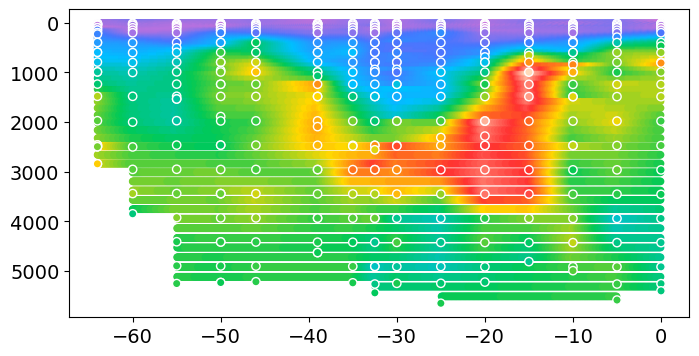

In [677]:
ironspecies = 'Fe'
feds = extract_geotraces_cruise('GP19')
fetmp = manual_interp(feds, 'latitude', model_z, model_lat, model_lon, ironspecies).sel(lat=slice(feds.latitude.min(),
                                                                                                   feds.latitude.max()))

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8,4))
ax.scatter(np.repeat(fetmp.lat, len(fetmp.z)), np.tile(fetmp.z, len(fetmp.lat)), c=fetmp,#.flatten(),
               cmap = cmapfe, vmin=0, vmax=1, s=20,) 
for i in range(len(feds.latitude)):
    z = feds.depth[i,:]
    fe = feds.var88[i,:]
    fe = fe.where(z>=0, drop=True)
    z = z.where(z>=0, drop=True)
    ax.scatter(np.full(len(z), feds.latitude[i]), z,  c=fe,
               cmap = cmapfe, vmin=0, vmax=1, 
               edgecolors='w',) 
ax.invert_yaxis()
plt.show()

In [678]:
%%time
datadir = '/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf_cycle4/'
files = sorted(glob(datadir + '/output*/ocean/oceanbgc-3d-fe-1-monthly-mean-3-sigfig-ym_*.nc'))
sfiles = sorted(glob(datadir + '/output*/ocean/ocean-3d-salt-1-monthly-mean-ym_*.nc'))
tfiles = sorted(glob(datadir + '/output*/ocean/ocean-3d-temp-1-monthly-mean-ym_*.nc'))
ht = xr.open_dataset(datadir + '/output780/ocean/ocean-2d-ht.nc').ht
httmp = ht*0
httmp = httmp.fillna(1)
targetlon = 190-360

def preproc(ds):
    return ds.sel(xt_ocean=targetlon, method='nearest').sel(yt_ocean=slice(feds.latitude.min(), feds.latitude.max()))

mindate = str(feds.date_time.min().values)[0:7]+'-01'
maxdate = str(feds.date_time.max().values)[0:7]+'-28'
print(mindate, maxdate)
fe_mod = xr.open_mfdataset(files, preprocess=preproc).sel(time=slice(mindate,maxdate)).fe.mean(dim='time').load()
temp = xr.open_mfdataset(tfiles, preprocess=preproc).sel(time=slice(mindate,maxdate)).temp.mean(dim='time').load() - 273.15 # CT [now in C]
salt = xr.open_mfdataset(sfiles, preprocess=preproc).sel(time=slice(mindate,maxdate)).salt.mean(dim='time').load() # practical salinity [psu]

2014-12-01 2015-02-28
CPU times: user 42.6 s, sys: 5.33 s, total: 47.9 s
Wall time: 47.3 s


Calculate in-situ density from temp and salinity

In [679]:
# First calculate absolute salinity
p = gsw.p_from_z(-salt.st_ocean, salt.yt_ocean)
salt = gsw.SA_from_SP(salt, p, salt.xt_ocean, salt.yt_ocean)
# Now calculate in-situ density
rho = gsw.density.rho(salt, temp, p) # [kg/m3]

Now convert fe from umol/m3 to nmol/kg [/density * 1000]

In [680]:
fe_mod = fe_mod/rho*1000

Now select out model fe at latitudes of stations. 

In [86]:
#fe_mod.sel(yt_ocean = feds.latitude, method='nearest') # THIS WORKS TO select multiple locations

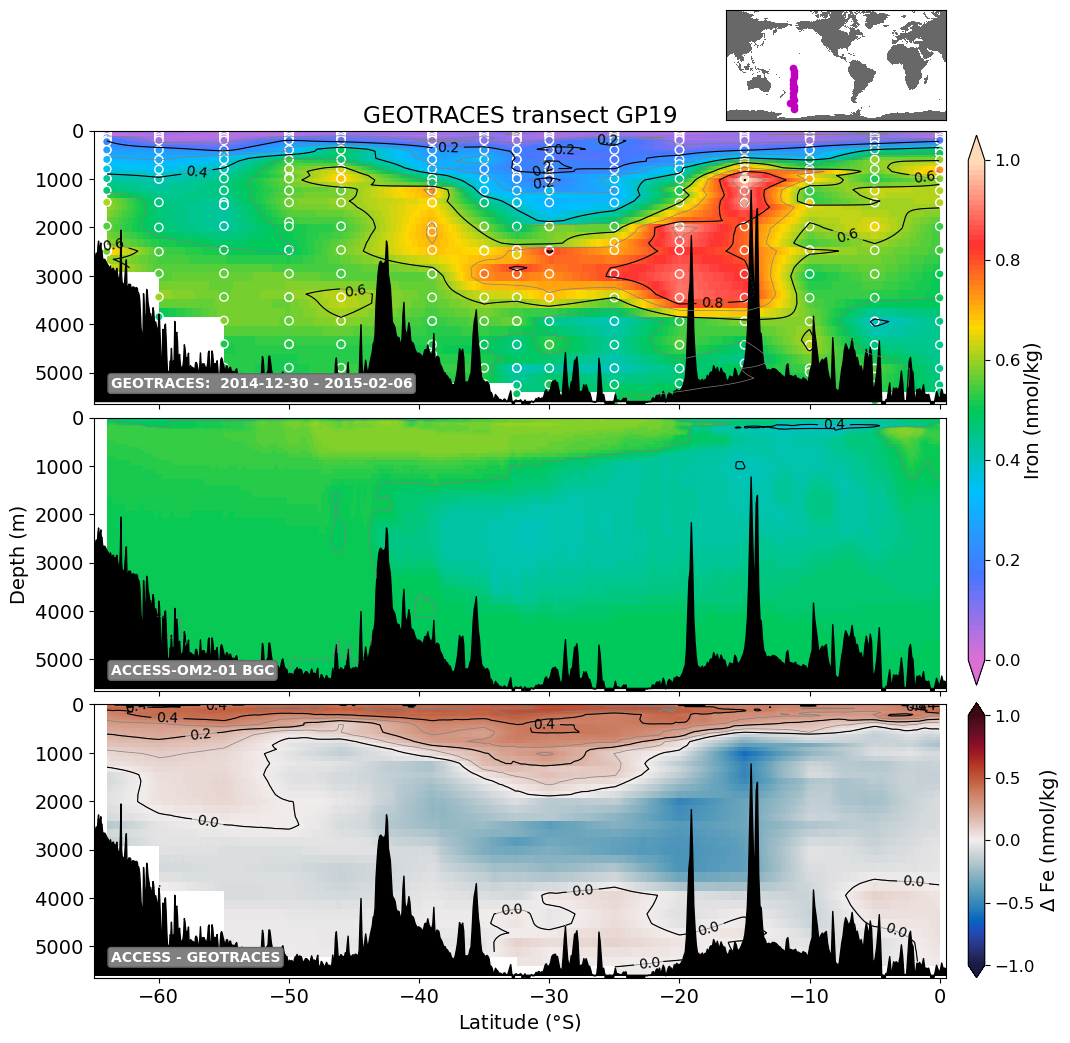

In [681]:
fig, axes = transect_fig_lat(fetmp, fe_mod, ironspecies)

axes[0].fill_between(ht.yt_ocean, xr.full_like(ht.isel(xt_ocean=0), 5600.), 
                     ht.sel(xt_ocean = 190-360, method='nearest'), color='k')
axes[1].fill_between(ht.yt_ocean, xr.full_like(ht.isel(xt_ocean=0), 5600.), 
                     ht.sel(xt_ocean = 190-360, method='nearest'), color='k')
axes[2].fill_between(ht.yt_ocean, xr.full_like(ht.isel(xt_ocean=0), 5600.), 
                     ht.sel(xt_ocean = 190-360, method='nearest'), color='k')


map_ax = fig.add_axes([0.7, 0.89, 0.2, 0.1])
map_ax.pcolormesh(ht.xt_ocean, ht.yt_ocean, httmp, cmap='Greys',vmax=1.5)
map_ax.set_xticks([])
map_ax.set_yticks([])
map_ax.scatter(feds.longitude-360, feds.latitude,c='m', s=20)

plt.show()
fig.savefig(f'../figs/GEOTRACES_transect_{str(feds.metavar1[0].values)[2:-1]}_Fe.jpg',bbox_inches='tight',dpi=200)

### GIPY06

In [682]:
feds = extract_geotraces_cruise('GIPY06')
ironspecies = 'Fe'
fetmp = manual_interp(feds, 'latitude', model_z, model_lat, model_lon, ironspecies).sel(lat=slice(feds.latitude.min(),
                                                                                                  feds.latitude.max()))
print(feds.longitude.min().values, feds.longitude.max().values)

139.67999267578125 146.32200622558594


In [683]:
datadir = '/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf_cycle4/'
files = sorted(glob(datadir + '/output*/ocean/oceanbgc-3d-fe-1-monthly-mean-3-sigfig-ym_*.nc'))
sfiles = sorted(glob(datadir + '/output*/ocean/ocean-3d-salt-1-monthly-mean-ym_*.nc'))
tfiles = sorted(glob(datadir + '/output*/ocean/ocean-3d-temp-1-monthly-mean-ym_*.nc'))
ht = xr.open_dataset(datadir + '/output780/ocean/ocean-2d-ht.nc').ht
httmp = ht*0
httmp = httmp.fillna(1)

def preproc(ds):
    return ds.sel(xt_ocean=slice(feds.longitude.min()-360,
                                 feds.longitude.max()-360)).sel(yt_ocean=slice(feds.latitude.min(),
                                                                               feds.latitude.max()))

mindate = str(feds.date_time.min().values)[0:7]+'-01'
maxdate = str(feds.date_time.max().values)[0:7]+'-28'
print(mindate, maxdate)
fe_mod = xr.open_mfdataset(files, preprocess=preproc).sel(time=slice(mindate,maxdate)).fe.mean(dim='time').load()
temp = xr.open_mfdataset(tfiles, preprocess=preproc).sel(time=slice(mindate,maxdate)).temp.mean(dim='time').load() - 273.15 # CT [now in C]
salt = xr.open_mfdataset(sfiles, preprocess=preproc).sel(time=slice(mindate,maxdate)).salt.mean(dim='time').load() # practical salinity [psu]

# Calculate in-situ density
# First calculate absolute salinity
p = gsw.p_from_z(-salt.st_ocean, salt.yt_ocean)
salt = gsw.SA_from_SP(salt, p, salt.xt_ocean, salt.yt_ocean)
# Now calculate in-situ density
rho = gsw.density.rho(salt, temp, p) # [kg/m3]

#Now convert fe from umol/m3 to nmol/kg [/density * 1000]
fe_mod = fe_mod/rho*1000

2008-03-01 2008-04-28


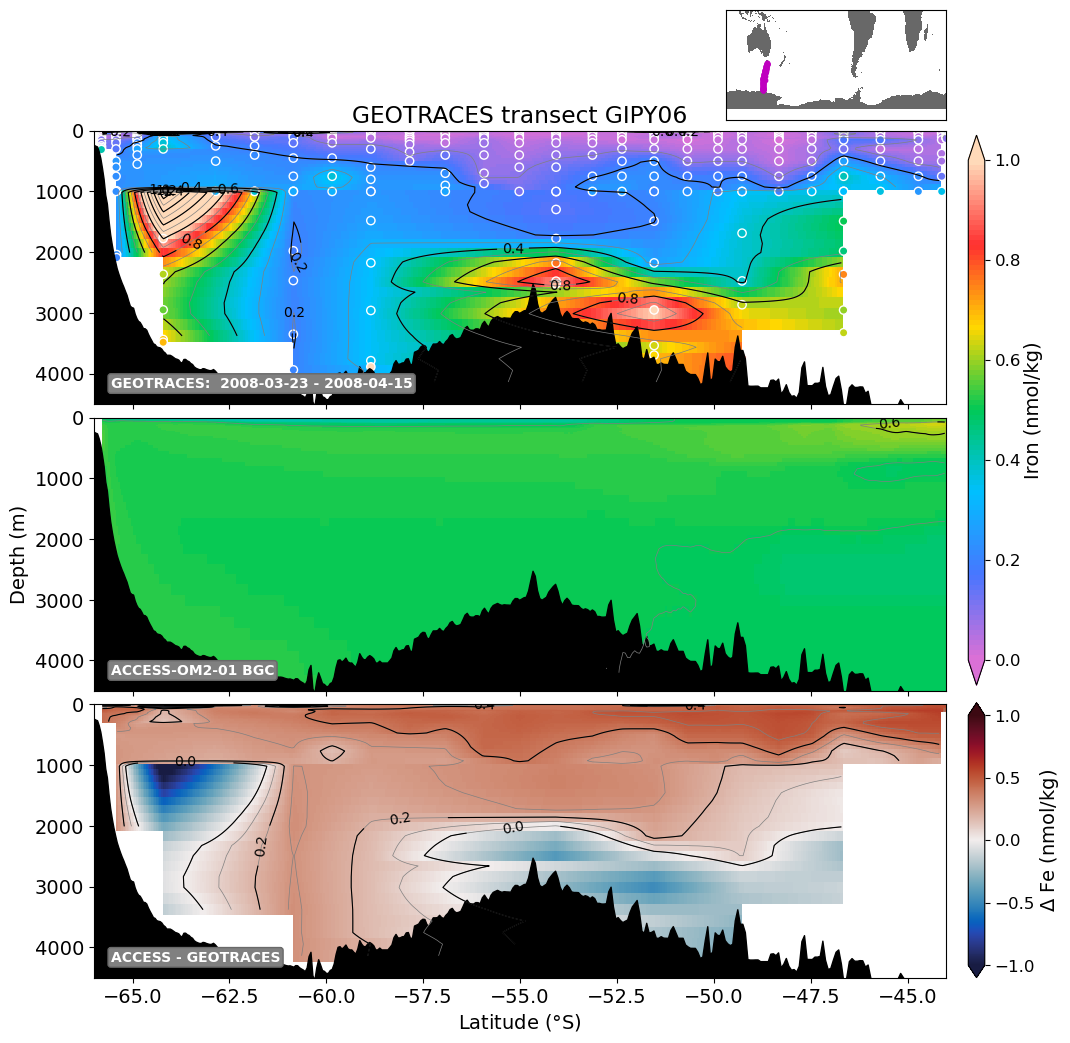

In [684]:
fig,axes = transect_fig_lat(fetmp, fe_mod.mean(dim='xt_ocean'), ironspecies)

axes[0].set_xlim([-66, -44])
axes[0].set_ylim([0,4500])
axes[0].invert_yaxis()

axes[0].fill_between(ht.yt_ocean, xr.full_like(ht.isel(xt_ocean=0), 5600.), 
                     ht.sel(xt_ocean = feds.longitude.mean().values-360, method='nearest'), color='k')
axes[1].fill_between(ht.yt_ocean, xr.full_like(ht.isel(xt_ocean=0), 5600.), 
                     ht.sel(xt_ocean = feds.longitude.mean().values-360, method='nearest'), color='k')
axes[2].fill_between(ht.yt_ocean, xr.full_like(ht.isel(xt_ocean=0), 5600.), 
                     ht.sel(xt_ocean = feds.longitude.mean().values-360, method='nearest'), color='k')


map_ax = fig.add_axes([0.7, 0.89, 0.2, 0.1])
map_ax.pcolormesh(ht.xt_ocean, ht.yt_ocean, httmp, cmap='Greys',vmax=1.5)
map_ax.set_xticks([])
map_ax.set_yticks([])
map_ax.set_ylim([-90,0])
map_ax.scatter(feds.longitude-360, feds.latitude,c='m', s=10)

plt.show()
fig.savefig(f'../figs/GEOTRACES_transect_{str(feds.metavar1[0].values)[2:-1]}_{ironspecies}.jpg',bbox_inches='tight',dpi=200)

Code to select out at specific longitudes and latitudes if required. 

In [340]:
fe_tmpmod = fe_mod.sel(yt_ocean=feds.latitude.values, method='nearest')
fe_sectionsmod = xr.full_like(fe_tmpmod.isel(xt_ocean=0), 0.)
for i, lat in enumerate(feds.latitude.values):
    fe_loop = fe_mod.sel(yt_ocean = lat, method='nearest').sel(xt_ocean= feds.longitude[i]-360, method='nearest')
    fe_sectionsmod[:,i] = fe_loop.values
    #print(i,lat, temp_loop.yt_ocean.values, temp_loop.xt_ocean.values, feds.latitude[i].values, feds.longitude[i].values)
fe_sectionsmod

fe_sectionsmod = fe_sectionsmod.sortby(fe_sectionsmod.yt_ocean)
fe_sectionsmod

### GI04

GEOTRACES iron

In [710]:
feds = extract_geotraces_cruise('GI04')
ironspecies = 'Fe'
fetmp = manual_interp(feds, 'latitude', model_z, model_lat, model_lon, ironspecies).sel(lat=slice(feds.latitude.min(),
                                                                               feds.latitude.max()))
print(feds.longitude.min().values, feds.longitude.max().values)
print(feds.latitude.min().values, feds.latitude.max().values)

40.08290100097656 86.02850341796875
-61.99980163574219 16.75079917907715


ACCESS iron

In [687]:
datadir = '/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf_cycle4/'
files = sorted(glob(datadir + '/output*/ocean/oceanbgc-3d-fe-1-monthly-mean-3-sigfig-ym_*.nc'))
sfiles = sorted(glob(datadir + '/output*/ocean/ocean-3d-salt-1-monthly-mean-ym_*.nc'))
tfiles = sorted(glob(datadir + '/output*/ocean/ocean-3d-temp-1-monthly-mean-ym_*.nc'))
ht = xr.open_dataset(datadir + '/output780/ocean/ocean-2d-ht.nc').ht
httmp = ht*0
httmp = httmp.fillna(1)

def preproc(ds):
    idx = np.where((ds.xt_ocean >= feds.longitude.min()) | (ds.xt_ocean <= feds.longitude.max()-360))[0]
    return ds.isel(xt_ocean=idx).sel(yt_ocean=slice(feds.latitude.min(),feds.latitude.max()))

mindate = str(feds.date_time.min().values)[0:7]+'-01'
maxdate = str(feds.date_time.max().values)[0:7]+'-28'
print(mindate, maxdate)
fe_mod = xr.open_mfdataset(files, preprocess=preproc).sel(time=slice(mindate,maxdate)).fe.mean(dim='time').load()
temp = xr.open_mfdataset(tfiles, preprocess=preproc).sel(time=slice(mindate,maxdate)).temp.mean(dim='time').load() - 273.15 # CT [now in C]
salt = xr.open_mfdataset(sfiles, preprocess=preproc).sel(time=slice(mindate,maxdate)).salt.mean(dim='time').load() # practical salinity [psu]

# Calculate in-situ density
# First calculate absolute salinity
p = gsw.p_from_z(-salt.st_ocean, salt.yt_ocean)
salt = gsw.SA_from_SP(salt, p, salt.xt_ocean, salt.yt_ocean)
# Now calculate in-situ density
rho = gsw.density.rho(salt, temp, p) # [kg/m3]

#Now convert fe from umol/m3 to nmol/kg [/density * 1000]
fe_mod = fe_mod/rho*1000

2009-11-01 2009-12-28


Code to select out at specific longitudes and latitudes if required. 

In [688]:
fe_tmpmod = fe_mod.sel(yt_ocean=feds.latitude.values, method='nearest')
fe_sectionsmod = xr.full_like(fe_tmpmod.isel(xt_ocean=0), 0.)
for i, lat in enumerate(feds.latitude.values):
    looplon = feds.longitude[i]
    if looplon > 80:
        looplon = looplon - 360
    fe_loop = fe_mod.sel(yt_ocean = lat, method='nearest').sel(xt_ocean= looplon, method='nearest')
    fe_sectionsmod[:,i] = fe_loop.values
    #print(i,lat, temp_loop.yt_ocean.values, temp_loop.xt_ocean.values, feds.latitude[i].values, feds.longitude[i].values)
fe_sectionsmod

fe_sectionsmod = fe_sectionsmod.sortby(fe_sectionsmod.yt_ocean)
#fe_sectionsmod

<xarray.DataArray (st_ocean: 75, yt_ocean: 15)>
array([[0.45638928, 0.45638928, 0.57195888, ..., 0.99135345, 1.11845597,
        1.21324705],
       [0.45638615, 0.45638615, 0.57195261, ..., 0.99134494, 1.11845219,
        1.21324269],
       [0.45638284, 0.45638284, 0.57194806, ..., 0.9913376 , 1.1184463 ,
        1.21323634],
       ...,
       [       nan,        nan, 0.48356822, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])
Coordinates:
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
    xt_ocean  float64 -279.9
  * yt_ocean  (yt_ocean) float64 -61.98 -61.98 -37.77 ... 9.999 14.01 16.71

Now interpolate between these points so we get an equivalent 'model' field as obtained from bottle data locations. 

In [689]:
fe_sectionsmod_interp = xr.full_like(fetmp.T, 0.)
fe_sectionsmod_interp = fe_sectionsmod_interp.rename({'lat':'yt_ocean', 'z':'st_ocean'})
for i, lat in enumerate(feds.latitude.values):
    modellat = fe_sectionsmod_interp.sel(yt_ocean = lat, method='nearest').yt_ocean
    idx = np.where(fe_sectionsmod_interp.yt_ocean == modellat)[0][0]
    
    fe_sectionsmod_interp[:,idx] = fe_sectionsmod[:,i].T.values

from scipy.interpolate import interp1d
for i in range(len(fe_sectionsmod_interp.st_ocean)):
    x = fe_sectionsmod.yt_ocean.values
    y = fe_sectionsmod[i,:]
    x = x[np.where(np.isfinite(y))]
    y = y.where(np.isfinite(y), drop=True)
    if len(x) >=2:
        f = interp1d(x,y, kind='linear',bounds_error=False, fill_value=np.nan)
        fe_sectionsmod_interp[i,:] = f(fe_sectionsmod_interp.yt_ocean.values)
    else:
        fe_sectionsmod_interp[i,:] = np.nan

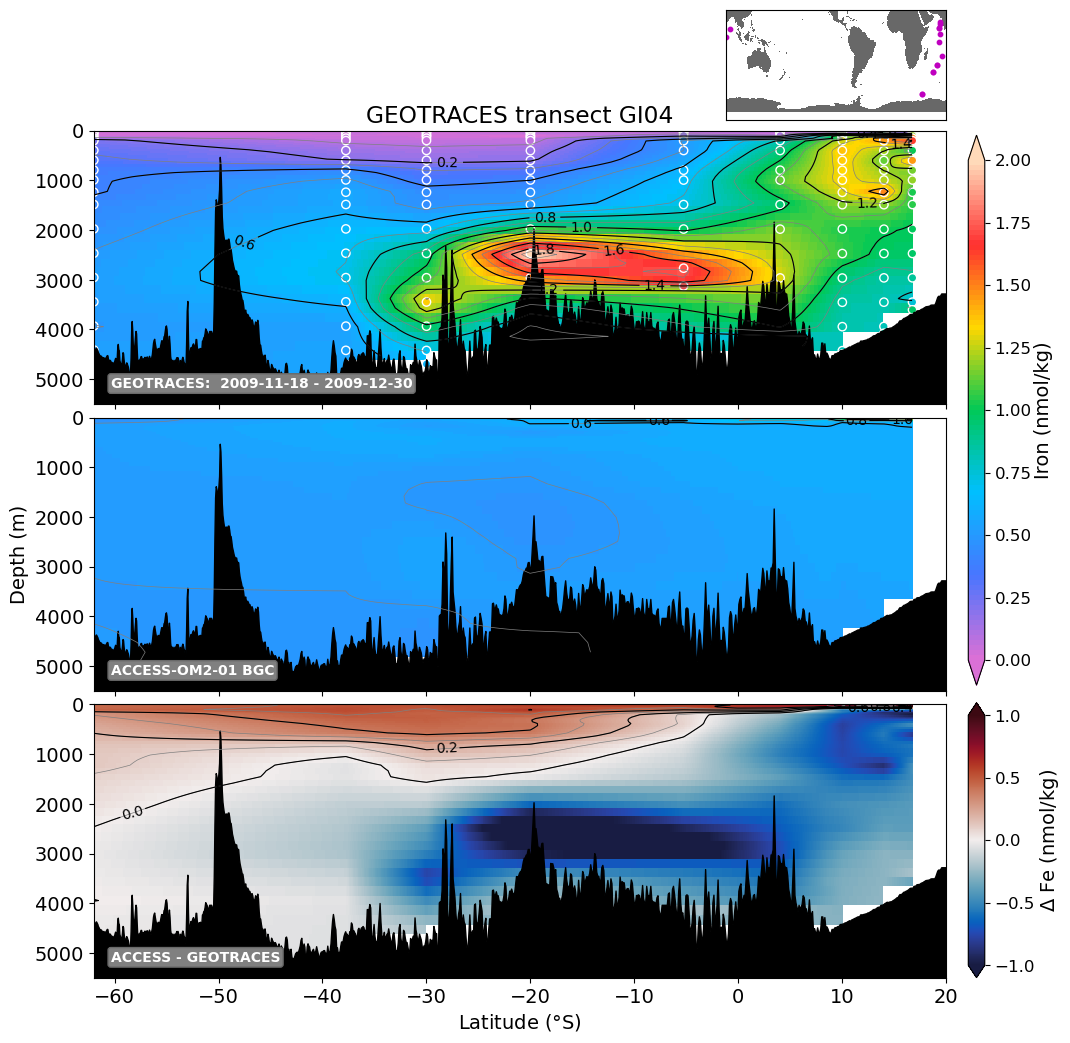

In [712]:
fig,axes = transect_fig_lat(fetmp, fe_sectionsmod_interp, ironspecies)

axes[0].set_xlim([-62, 20])
axes[0].set_ylim([0,5500])
axes[0].invert_yaxis()

axes[0].fill_between(ht.yt_ocean, xr.full_like(ht.isel(xt_ocean=0), 5600.), 
                     ht.sel(xt_ocean = 64, method='nearest'), color='k')
axes[1].fill_between(ht.yt_ocean, xr.full_like(ht.isel(xt_ocean=0), 5600.), 
                     ht.sel(xt_ocean = 64, method='nearest'), color='k')
axes[2].fill_between(ht.yt_ocean, xr.full_like(ht.isel(xt_ocean=0), 5600.), 
                     ht.sel(xt_ocean = 64, method='nearest'), color='k')

map_ax = fig.add_axes([0.7, 0.89, 0.2, 0.1])
map_ax.pcolormesh(ht.xt_ocean, ht.yt_ocean, httmp, cmap='Greys',vmax=1.5)
map_ax.set_xticks([])
map_ax.set_yticks([])
map_ax.set_ylim([-90,30])
scatterlons, scatterlats  = feds.longitude, feds.latitude
scatterlats = scatterlats[scatterlons>80]
scatterlons = scatterlons[scatterlons>80]
map_ax.scatter(scatterlons-360, scatterlats,c='m', s=10)
scatterlons, scatterlats  = feds.longitude, feds.latitude
scatterlats = scatterlats[scatterlons<=80]
scatterlons = scatterlons[scatterlons<=80]
map_ax.scatter(scatterlons, scatterlats,c='m', s=10)

plt.show()
fig.savefig(f'../figs/GEOTRACES_transect_{str(feds.metavar1[0].values)[2:-1]}_{ironspecies}.jpg',bbox_inches='tight',dpi=200)

### GA10

In [756]:
feds = extract_geotraces_cruise('GA10')
feds.longitude[feds['longitude'] > 80] = feds.longitude[feds['longitude'] > 80]-360
ironspecies = 'Fe'
fetmp = manual_interp(feds, 'longitude', model_z, model_lat, model_lon[2200:3000], ironspecies).sel(lon=slice(feds.longitude.min(),
                                                                                                   feds.longitude.max()))
print(feds.longitude.min().values, feds.longitude.max().values)
print(feds.latitude.min().values, feds.latitude.max().values)

-54.90289306640625 18.128400802612305
-40.28770065307617 -34.043701171875


In [757]:
datadir = '/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf_cycle4/'
files = sorted(glob(datadir + '/output*/ocean/oceanbgc-3d-fe-1-monthly-mean-3-sigfig-ym_*.nc'))
sfiles = sorted(glob(datadir + '/output*/ocean/ocean-3d-salt-1-monthly-mean-ym_*.nc'))
tfiles = sorted(glob(datadir + '/output*/ocean/ocean-3d-temp-1-monthly-mean-ym_*.nc'))
ht = xr.open_dataset(datadir + '/output780/ocean/ocean-2d-ht.nc').ht
httmp = ht*0
httmp = httmp.fillna(1)

def preproc(ds):
    return ds.sel(xt_ocean=slice(feds.longitude.min(),
                                 feds.longitude.max())).sel(yt_ocean=slice(feds.latitude.min(),
                                                                               feds.latitude.max()))
mindate = str(feds.date_time.min().values)[0:7]+'-01'
mindate = '2011-12-01'
maxdate = str(feds.date_time.max().values)[0:7]+'-28'
print(mindate, maxdate)
fe_mod = xr.open_mfdataset(files, preprocess=preproc).sel(time=slice(mindate,maxdate)).fe.mean(dim='time').load()
temp = xr.open_mfdataset(tfiles, preprocess=preproc).sel(time=slice(mindate,maxdate)).temp.mean(dim='time').load() - 273.15 # CT [now in C]
salt = xr.open_mfdataset(sfiles, preprocess=preproc).sel(time=slice(mindate,maxdate)).salt.mean(dim='time').load() # practical salinity [psu]

# Calculate in-situ density
# First calculate absolute salinity
p = gsw.p_from_z(-salt.st_ocean, salt.yt_ocean)
salt = gsw.SA_from_SP(salt, p, salt.xt_ocean, salt.yt_ocean)
# Now calculate in-situ density
rho = gsw.density.rho(salt, temp, p) # [kg/m3]

#Now convert fe from umol/m3 to nmol/kg [/density * 1000]
fe_mod = fe_mod/rho*1000

2011-12-01 2012-01-28


Code to select out at specific longitudes and latitudes if required. 

In [758]:
fe_tmpmod = fe_mod.sel(xt_ocean=feds.longitude.values, method='nearest')
fe_sectionsmod = xr.full_like(fe_tmpmod.isel(yt_ocean=0), 0.)
for i, lon in enumerate(feds.longitude.values):
    looplat = feds.latitude[i]
    fe_loop = fe_mod.sel(xt_ocean = lon, method='nearest').sel(yt_ocean= looplat, method='nearest')
    fe_sectionsmod[:,i] = fe_loop.values
    #print(i,lat, temp_loop.yt_ocean.values, temp_loop.xt_ocean.values, feds.latitude[i].values, feds.longitude[i].values)
fe_sectionsmod

fe_sectionsmod = fe_sectionsmod.sortby(fe_sectionsmod.xt_ocean)
#fe_sectionsmod

Now interpolate between these points so we get an equivalent 'model' field as obtained from bottle data locations. 

In [759]:
fe_sectionsmod_interp = xr.full_like(fetmp.T, 0.)
fe_sectionsmod_interp = fe_sectionsmod_interp.rename({'lon':'xt_ocean', 'z':'st_ocean'})
for i, lon in enumerate(feds.longitude.values):
    modellon = fe_sectionsmod_interp.sel(xt_ocean = lon, method='nearest').xt_ocean
    idx = np.where(fe_sectionsmod_interp.xt_ocean == modellon)[0][0]
    
    fe_sectionsmod_interp[:,idx] = fe_sectionsmod[:,i].T.values

from scipy.interpolate import interp1d
for i in range(len(fe_sectionsmod_interp.st_ocean)):
    x = fe_sectionsmod.xt_ocean.values
    y = fe_sectionsmod[i,:]
    x = x[np.where(np.isfinite(y))]
    y = y.where(np.isfinite(y), drop=True)
    if len(x) >=2:
        f = interp1d(x,y, kind='linear',bounds_error=False, fill_value=np.nan)
        fe_sectionsmod_interp[i,:] = f(fe_sectionsmod_interp.xt_ocean.values)
    else:
        fe_sectionsmod_interp[i,:] = np.nan

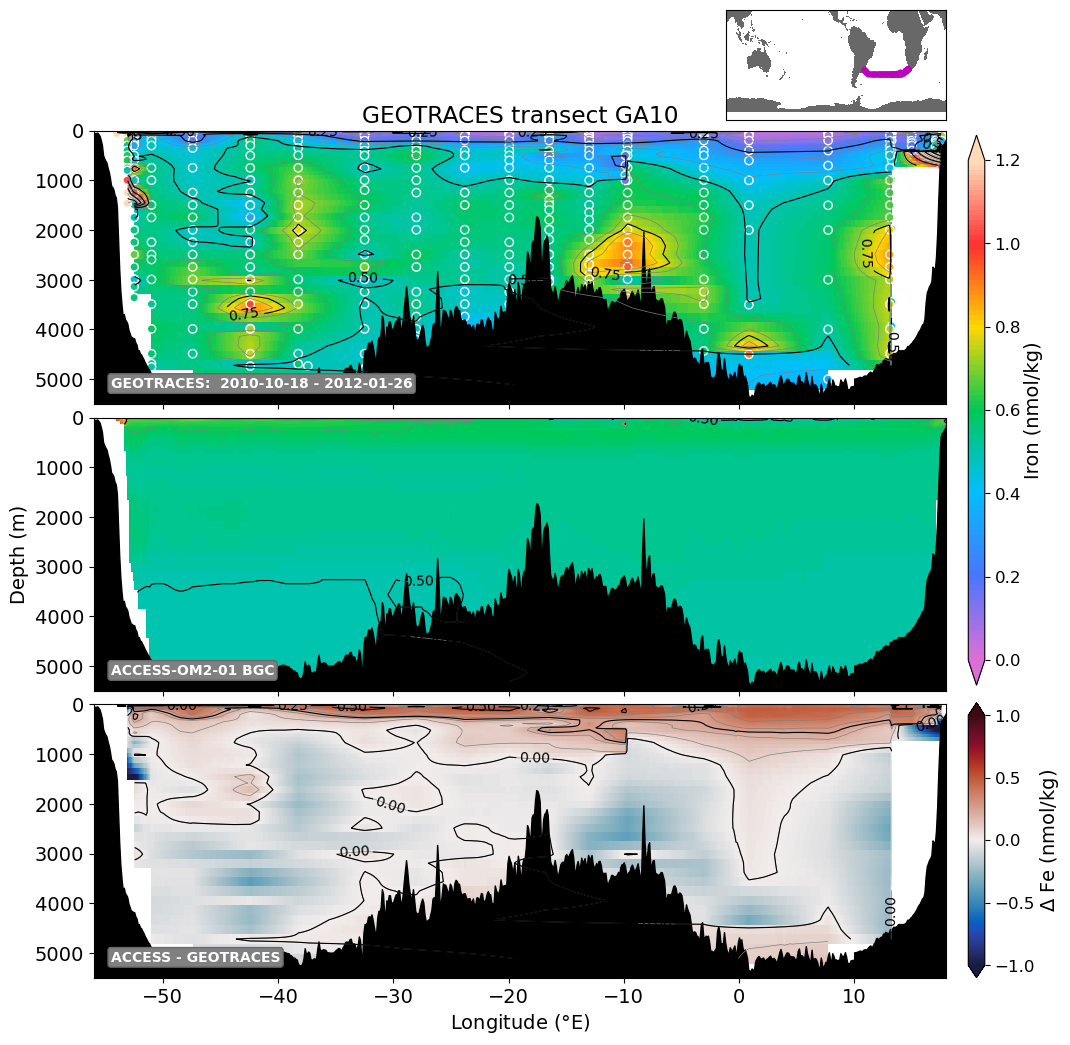

In [760]:
fig,axes = transect_fig_lon(fetmp, fe_sectionsmod_interp, ironspecies)

axes[0].set_xlim([-56, 18])
axes[0].set_ylim([0,5500])
axes[0].invert_yaxis()

axes[0].fill_between(ht.xt_ocean[:-700], xr.full_like(ht.isel(yt_ocean=0)[:-700], 5500.), 
                     ht.sel(yt_ocean = feds.latitude.mean().values, method='nearest')[:-700], color='k')
axes[1].fill_between(ht.xt_ocean[:-700], xr.full_like(ht.isel(yt_ocean=0)[:-700], 5500.), 
                     ht.sel(yt_ocean = feds.latitude.mean().values, method='nearest')[:-700], color='k')
axes[2].fill_between(ht.xt_ocean[:-700], xr.full_like(ht.isel(yt_ocean=0)[:-700], 5500.), 
                     ht.sel(yt_ocean = feds.latitude.mean().values, method='nearest')[:-700], color='k')
axes[0].fill_between(ht.xt_ocean[-700:], xr.full_like(ht.isel(yt_ocean=0)[-700:], 5500.), 
                     ht.sel(yt_ocean = feds.latitude.max().values, method='nearest')[-700:], color='k')
axes[1].fill_between(ht.xt_ocean[-700:], xr.full_like(ht.isel(yt_ocean=0)[-700:], 5500.), 
                     ht.sel(yt_ocean = feds.latitude.max().values, method='nearest')[-700:], color='k')
axes[2].fill_between(ht.xt_ocean[-700:], xr.full_like(ht.isel(yt_ocean=0)[-700:], 5500.), 
                     ht.sel(yt_ocean = feds.latitude.max().values, method='nearest')[-700:], color='k')

map_ax = fig.add_axes([0.7, 0.89, 0.2, 0.1])
map_ax.pcolormesh(ht.xt_ocean, ht.yt_ocean, httmp, cmap='Greys',vmax=1.5)
map_ax.set_xticks([])
map_ax.set_yticks([])
map_ax.set_ylim([-90,30])
scatterlons, scatterlats  = feds.longitude, feds.latitude
map_ax.scatter(scatterlons, scatterlats,c='m', s=10)


plt.show()
fig.savefig(f'../figs/GEOTRACES_transect_{str(feds.metavar1[0].values)[2:-1]}_{ironspecies}.jpg',bbox_inches='tight',dpi=200)

### GP13

In [749]:
feds = extract_geotraces_cruise('GP13')
feds.longitude[feds['longitude'] > 80] = feds.longitude[feds['longitude'] > 80]-360
feds = feds.where(feds.longitude != -168.998 ,drop=True)
ironspecies = 'Fe'
fetmp = manual_interp(feds, 'longitude', model_z, model_lat, model_lon[700:1310], ironspecies).sel(lon=slice(feds.longitude.min(),
                                                                                                   feds.longitude.max()))
print(feds.longitude.min().values, feds.longitude.max().values)
print(feds.latitude.min().values, feds.latitude.max().values)

-206.49899291992188 -150.0030059814453
-35.009300231933594 -28.97610092163086


In [750]:
datadir = '/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf_cycle4/'
files = sorted(glob(datadir + '/output*/ocean/oceanbgc-3d-fe-1-monthly-mean-3-sigfig-ym_*.nc'))
sfiles = sorted(glob(datadir + '/output*/ocean/ocean-3d-salt-1-monthly-mean-ym_*.nc'))
tfiles = sorted(glob(datadir + '/output*/ocean/ocean-3d-temp-1-monthly-mean-ym_*.nc'))
ht = xr.open_dataset(datadir + '/output780/ocean/ocean-2d-ht.nc').ht
httmp = ht*0
httmp = httmp.fillna(1)

def preproc(ds):
    return ds.sel(xt_ocean=slice(feds.longitude.min(),
                                 feds.longitude.max())).sel(yt_ocean=slice(feds.latitude.min(),
                                                                               feds.latitude.max()))
mindate = str(feds.date_time.min().values)[0:7]+'-01'
#mindate = '2011-12-01'
maxdate = str(feds.date_time.max().values)[0:7]+'-28'
print(mindate, maxdate)
fe_mod = xr.open_mfdataset(files, preprocess=preproc).sel(time=slice(mindate,maxdate)).fe.mean(dim='time').load()
temp = xr.open_mfdataset(tfiles, preprocess=preproc).sel(time=slice(mindate,maxdate)).temp.mean(dim='time').load() - 273.15 # CT [now in C]
salt = xr.open_mfdataset(sfiles, preprocess=preproc).sel(time=slice(mindate,maxdate)).salt.mean(dim='time').load() # practical salinity [psu]

# Calculate in-situ density
# First calculate absolute salinity
p = gsw.p_from_z(-salt.st_ocean, salt.yt_ocean)
salt = gsw.SA_from_SP(salt, p, salt.xt_ocean, salt.yt_ocean)
# Now calculate in-situ density
rho = gsw.density.rho(salt, temp, p) # [kg/m3]

#Now convert fe from umol/m3 to nmol/kg [/density * 1000]
fe_mod = fe_mod/rho*1000

2011-05-01 2011-06-28


Code to select out at specific longitudes and latitudes if required. 

In [751]:
fe_tmpmod = fe_mod.sel(xt_ocean=feds.longitude.values, method='nearest')
fe_sectionsmod = xr.full_like(fe_tmpmod.isel(yt_ocean=0), 0.)
for i, lon in enumerate(feds.longitude.values):
    looplat = feds.latitude[i]
    fe_loop = fe_mod.sel(xt_ocean = lon, method='nearest').sel(yt_ocean= looplat, method='nearest')
    fe_sectionsmod[:,i] = fe_loop.values
    #print(i,lat, temp_loop.yt_ocean.values, temp_loop.xt_ocean.values, feds.latitude[i].values, feds.longitude[i].values)
fe_sectionsmod

fe_sectionsmod = fe_sectionsmod.sortby(fe_sectionsmod.xt_ocean)
#fe_sectionsmod

Now interpolate between these points so we get an equivalent 'model' field as obtained from bottle data locations. 

In [752]:
fe_sectionsmod_interp = xr.full_like(fetmp.T, 0.)
fe_sectionsmod_interp = fe_sectionsmod_interp.rename({'lon':'xt_ocean', 'z':'st_ocean'})
for i, lon in enumerate(feds.longitude.values):
    modellon = fe_sectionsmod_interp.sel(xt_ocean = lon, method='nearest').xt_ocean
    idx = np.where(fe_sectionsmod_interp.xt_ocean == modellon)[0][0]
    
    fe_sectionsmod_interp[:,idx] = fe_sectionsmod[:,i].T.values

from scipy.interpolate import interp1d
for i in range(len(fe_sectionsmod_interp.st_ocean)):
    x = fe_sectionsmod.xt_ocean.values
    y = fe_sectionsmod[i,:]
    x = x[np.where(np.isfinite(y))]
    y = y.where(np.isfinite(y), drop=True)
    if len(x) >=2:
        f = interp1d(x,y, kind='linear',bounds_error=False, fill_value=np.nan)
        fe_sectionsmod_interp[i,:] = f(fe_sectionsmod_interp.xt_ocean.values)
    else:
        fe_sectionsmod_interp[i,:] = np.nan

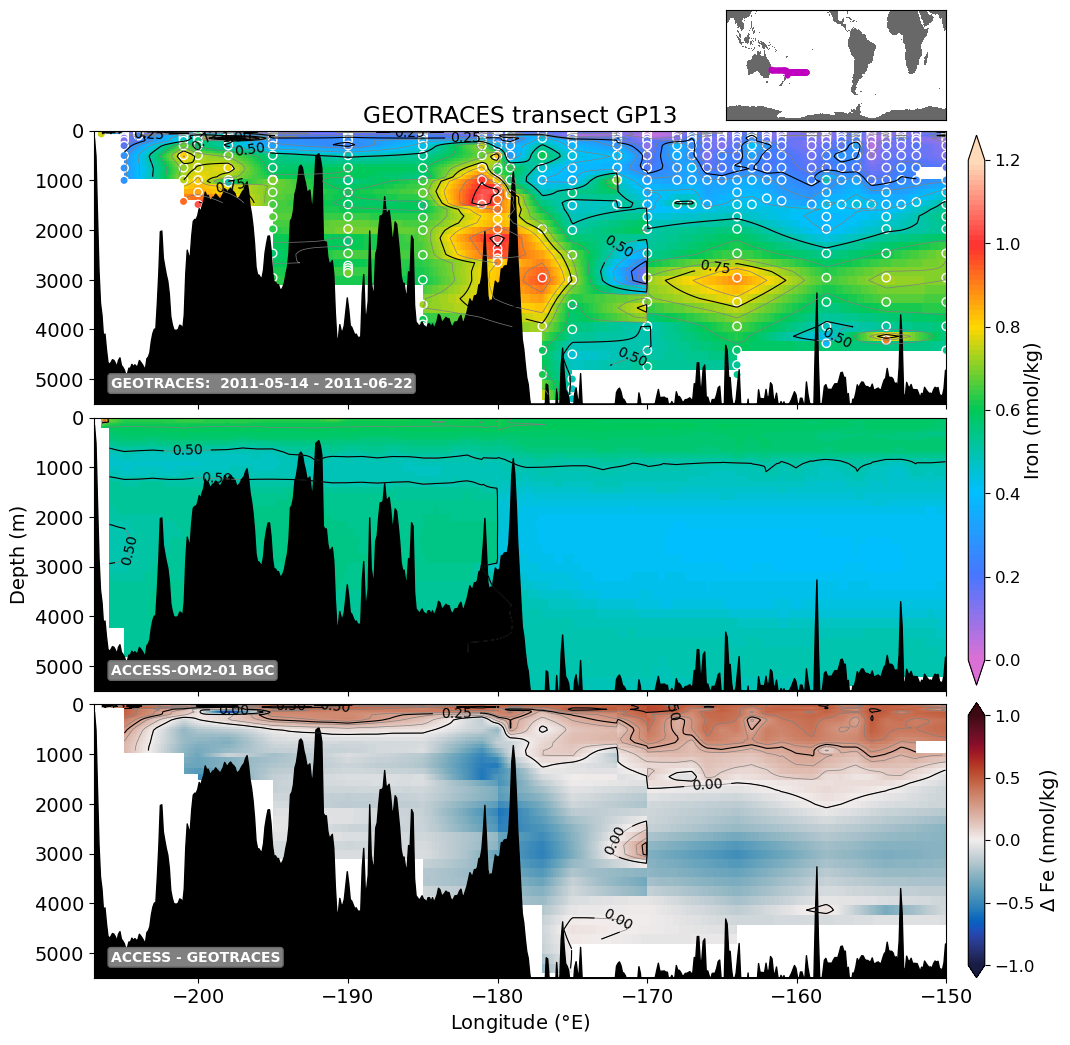

In [755]:
fig,axes = transect_fig_lon(fetmp, fe_sectionsmod_interp, ironspecies)

axes[0].set_xlim([-207, -150])
axes[0].set_ylim([0,5500])
axes[0].invert_yaxis()

axes[0].fill_between(ht.xt_ocean, xr.full_like(ht.isel(yt_ocean=0), 5500.), 
                     ht.sel(yt_ocean = feds.latitude.mean().values, method='nearest'), color='k')
axes[1].fill_between(ht.xt_ocean, xr.full_like(ht.isel(yt_ocean=0), 5500.), 
                     ht.sel(yt_ocean = feds.latitude.mean().values, method='nearest'), color='k')
axes[2].fill_between(ht.xt_ocean, xr.full_like(ht.isel(yt_ocean=0), 5500.), 
                     ht.sel(yt_ocean = feds.latitude.mean().values, method='nearest'), color='k')

map_ax = fig.add_axes([0.7, 0.89, 0.2, 0.1])
map_ax.pcolormesh(ht.xt_ocean, ht.yt_ocean, httmp, cmap='Greys',vmax=1.5)
map_ax.set_xticks([])
map_ax.set_yticks([])
map_ax.set_ylim([-80,30])
scatterlons, scatterlats  = feds.longitude, feds.latitude
map_ax.scatter(scatterlons, scatterlats,c='m', s=10)


plt.show()
fig.savefig(f'../figs/GEOTRACES_transect_{str(feds.metavar1[0].values)[2:-1]}_{ironspecies}.jpg',bbox_inches='tight',dpi=200)

### End

var2:
    long_name :
    DEPTH
units :
    m
comment :
    Depth below sea surface calculated from pressure
    
    
var88:
  long_name :
    Fe_D_CONC_BOTTLE
units :
    nmol/kg
comment :
    Concentration of dissolved Fe
    
var89:
    
    